<a href="https://colab.research.google.com/github/ayrna/deep-learning-with-python-notebooks/blob/master/chapter08_intro-to-dl-for-computer-vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este cuaderno está basado en los cuadernos del libro [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition).

Los contenidos del libro están disponibles en [deeplearningwithpython.io](https://deeplearningwithpython.io).

In [ ]:
!pip install keras keras-hub --upgrade -q

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

# Clasificación de imágenes

Las redes CNN son actualmente el estado del arte en visión por computador y han desbancado a otras opciones tradicionales.

## Introducción a las redes CNN

Vamos a comenzar construyendo una red CNN simple para la base de datos de clasificación de dígitos MNIST, una tarea que ya habéis visto en esta asignatura y en la que obtuvistéis alrededor del 98% de precisión usando redes completamente conectadas.

**Generando una red CNN simple**

In [ ]:
import keras
from keras import layers

inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Como se puede observar, la red es un concatenación de capas `Conv2D` y `MaxPooling2D`. Un red CNN suele aceptar como entrada tensores del tipo `(image_height, image_width,image_channels)`, lo que se traduce en `(28,28,1)` para este conjunto de datos.

**Mostrar el resumen del modelo**

In [ ]:
model.summary(line_length=80)

Se observa como la salida de estas capas especiales es de tipo `(height, width, channels)`, de manera que, conforme avanzamos en la red, el alto y el ancho va disminuyendo y el número de canales (que está impuesto por el número de filtros que ponemos en cada capa) va aumentando. Después de la última capa convolucional, tenemos 256 canales de 3x3 píxeles. El siguiente paso sería pasar esta salida a una capa densa (tipo MLP). El problema es que dicha capa procesa vectores de una dimensión, por lo que tenemos que *alisar* (*flatten*) el tensor tridimensional que proporcion la última capa convolucional. Para ello usamos `GlobalAveragePooling2D` que calculará la media de cada mapa de características de `3x3` y la pondrá en un vector, resultando en 256 componentes. Finalmente, añadimos una capa densa de 10 neuronas que realizará la tarea de clasificación.

**Entrenar la CNN en las imágenes MNIST**

In [ ]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(train_images, train_labels, epochs=5, batch_size=64)

**Evaluando la red construida**

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

En solo 5 épocas obtenemos resultados de más de 99% de precisión.

### La operación de convolución

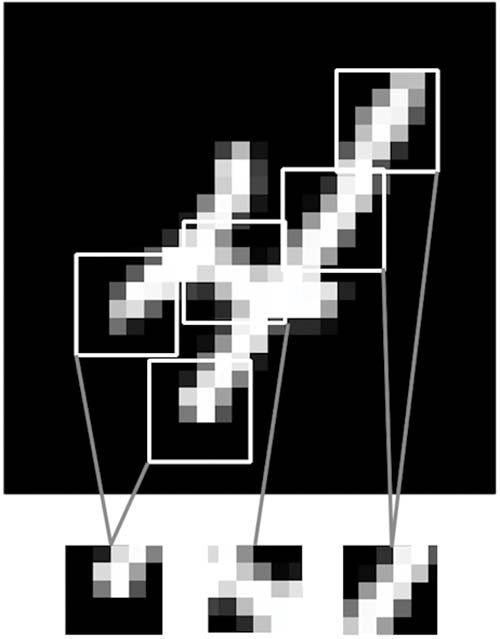

[Fuente imagen Collet 2022]

La diferencia fundamental entre una capa densamente conectada y una capa de convolución es la siguiente: las capas densas aprenden patrones globales en su espacio de características de entrada (por ejemplo, para un dígito MNIST, patrones que implican a todos los píxeles), mientras que las capas de convolución aprenden patrones locales -en el caso de las imágenes, patrones que se encuentran en pequeñas ventanas 2D de las entradas. En el ejemplo anterior, estas ventanas eran todas de `3×3`.

Esto proporciona a las CNN dos características fundamentales en su desempeño e ideales para tratar imágenes:
- *Los patrones que aprenden son invariantes respecto a la traslación*. Tras aprender un determinado patrón en la esquina inferior derecha de una imagen, una CNN puede reconocerlo en cualquier lugar: por ejemplo, en la esquina superior izquierda. Un modelo densamente conectado tendría que aprender el patrón de nuevo si apareciera en una nueva ubicación. Esto hace que las CNNs sean eficientes en el procesamiento de datos de imágenes (porque el mundo visual es fundamentalmente invariante de la traslación): necesitan menos muestras de entrenamiento para aprender representaciones que tengan poder de generalización.
- *Pueden aprender jerarquías espaciales de patrones*. Una primera capa de convolución aprenderá pequeños patrones locales, como bordes, una segunda capa de convolución aprenderá patrones más grandes formados por las características de las primeras capas, y así sucesivamente. Esto permite a las redes de convolución aprender de forma eficaz conceptos visuales cada vez más complejos y abstractos, ya que el mundo visual es fundamentalmente jerárquico desde el punto de vista espacial.

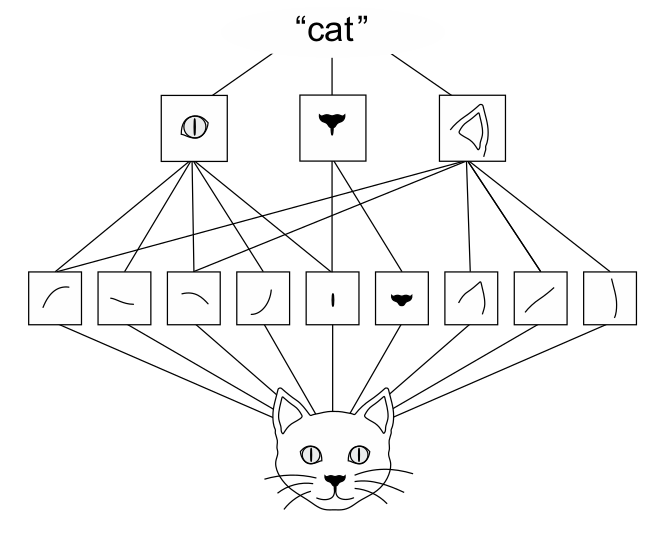

[Fuente imagen Collet 2022]

Las operaciones de convolución se basan en filtros entrenables, normalmente con dimensiones `3x3` o `5x5`. Sin embargo, si la imagen es RGB (es decir, contiene información de color) estos filtros tendrán una profundidad de 3 dimensiones. Los filtros buscan un determinado patrón en la imagen.

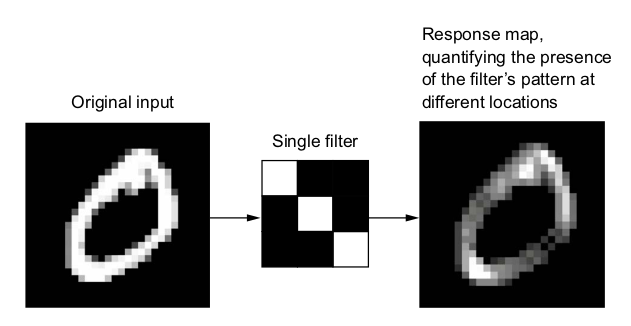

[Fuente Imagen Collet 2022]

#### Como tratar los bordes de la imagen (opción de relleno)

En principio, los filtros no podría aplicarse en los bordes de la imagen, ya que superaríamos (por exceso o por defecto) los límites de la misma. Observa como en nuestra red sencilla para MNIST, la capa Conv2D generaba un mapa de `26x26`.

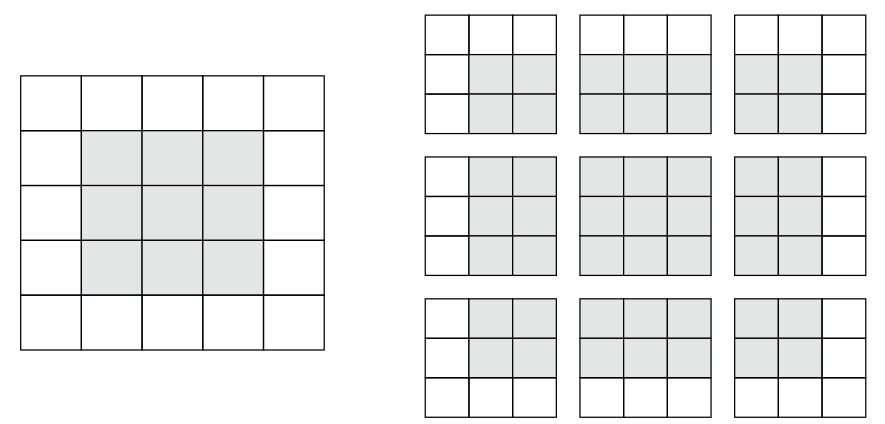

[Fuente imagen Collet 2022]

Una posibilidad alternativa a reducir las dimensiones de la imagen es usar *Padding* o relleno, es decir, incluir píxeles artificiales en los bordes que se suelen poner a cero.

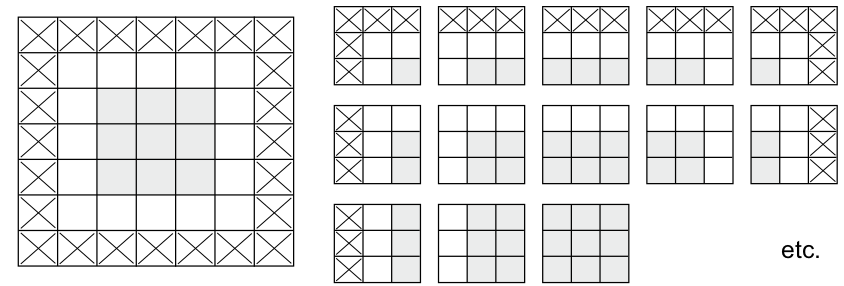

[Fuente imagen Chollet 2022]

Cuando usamos las capas `Conv2D` esto lo configuramos con el argumento `padding`, que puede tomar valores:
- `valid`: no se aplica padding y se reduce el tamaño.
- `same`: incluir el padding necesario para que el tamaño termine siendo el mismo.

#### Zancada o *stride*

Al aplicar el filtro, podemos ir avanzando píxel a píxel, es decir, que todas las ventanas sean continuas. Esto sería similar a dar zancadas (*strides*) de valor 1. Sin embargo, el valor de *stride* podría incrementarse, lo que reduciría el tamaño del mapa generado por cada filtro.

Convolución `3x3` con `stride=2`

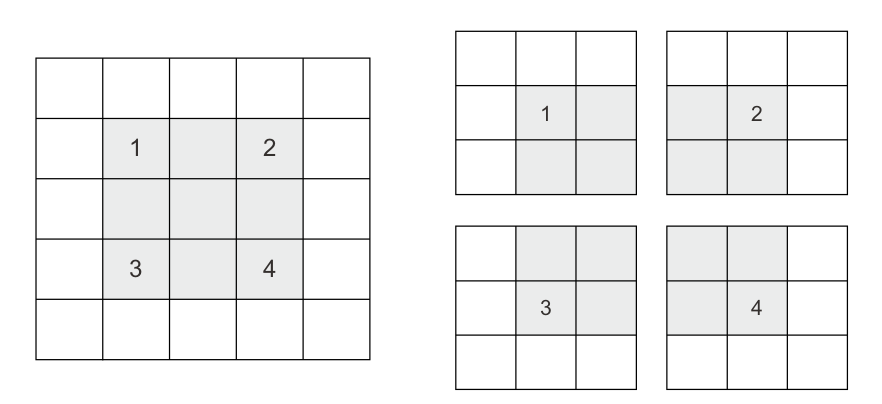

[Fuente imagen Chollet 2022]

Sin embargo, lo habitual (y más recomendable) es aplicar algún tipo de *pooling* para ir reduciendo el tamaño de los mapas y dejar `stride=1`.

### La operación de max-pooling

Habrás observado como el tamaño de los mapas del ejemplo de MNIST se reduce a la mitad cada vez que aplicamos la capa `MaxPooling2D`. ¿Por qué?

El max-pooling consiste en extraer ventanas del mapa de entrada y devolver el máximo de cada ventana, siendo similar a un filtro que siempre calcula el máximo (sin pesos que entrenar) y que se suele aplicar con dimensión `2x2` y con `stride=2.

¿Por qué hacer esto? Otra opción sería ir aplicando las capas de convolución sin reducir los tamaños (o simplemente con la reducción que conlleva la aplicación del filtro.

**Red CNN incorrectamente configuranda sin capas de max-pooling**

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_no_max_pool.summary()

¿Qué tiene de malo esta configuración? Dos cosas:
- No es propicio para el aprendizaje de una jerarquía espacial de características. Las ventanas de `3×3` de la tercera capa sólo contendrán información procedente de las ventanas de `7×7` de la entrada inicial. Los patrones de alto nivel aprendidos por la CNN seguirán siendo muy pequeños con respecto a la entrada inicial, lo que puede no ser suficiente para aprender a clasificar dígitos (**¡intenta reconocer un dígito mirándolo sólo a través de ventanas de 7 × 7 píxeles!**). Necesitamos que las características de la última capa de convolución contengan información sobre la totalidad de la entrada.
- El mapa de características final tiene `22×22×128 = 61.952` coeficientes totales por muestra. Esto es enorme. Si lo aplanamos para ponerle encima una capa densa de tamaño *10*, esa capa tendría más de medio millón de parámetros. Esto es demasiado para un modelo tan pequeño y daría lugar a un intenso sobreajuste.

En resumen, la razón para utilizar el downsampling es reducir el número de coeficientes del mapa de características que hay que procesar, así como inducir jerarquías de filtros espaciales haciendo que las capas de convolución exitosas analicen ventanas cada vez más grandes (en términos de la fracción de la entrada original que cubren).

Tened en cuenta que la agrupación de máximos no es la única forma de conseguir este tipo de reducción de la muestra. Como ya sabes, también puedes utilizar *strides* en la capa de convolución previa. Y se puede utilizar el pooling por promediado en lugar del pooling por máximo, donde cada parche de entrada local se transforma tomando el valor medio de cada canal sobre el parche, en lugar del máximo. Pero la agrupación máxima suele funcionar mejor que estas soluciones alternativas. La razón es que los rasgos tienden a codificar la presencia espacial de algún patrón o concepto en los diferentes mosaicos del mapa de características (de ahí el término mapa de rasgos), y es más informativo fijarse en la presencia máxima de los diferentes rasgos que en su presencia media. La estrategia de submuestreo más razonable es producir primero mapas densos de rasgos (mediante convoluciones sin *stride*) y luego observar la activación máxima de los rasgos en pequeños parches, en lugar de observar ventanas más dispersas de las entradas (mediante convoluciones con *stride*) o promediar parches de entrada, lo que podría hacer que se perdiera o diluyera información sobre la presencia de rasgos.

## Entrenando una CNN desde cero con un conjunto de datos pequeño

### La necesidad de afrontar problemas con conjuntos de datos pequeños

Tener que entrenar un modelo de clasificación de imágenes **con muy pocos datos** es una situación común, que probablemente encontrarás en la práctica si alguna vez te dedicas a la visión por ordenador en un contexto profesional. Unas «pocas» muestras pueden significar desde unos cientos hasta unas decenas de miles de imágenes. Como ejemplo práctico, nos centraremos en clasificar imágenes como perros o gatos en un conjunto de datos que contiene `5.000` imágenes de gatos y perros (`2.500` gatos, `2.500` perros). Utilizaremos `2.000` imágenes para el entrenamiento, `1.000` para la validación y `2.000` para *testing*.

En esta sección, revisaremos una estrategia básica para abordar este problema: entrenar un nuevo modelo desde cero utilizando los pocos datos de los que se dispone. Empezaremos entrenando ingenuamente una pequeña CNN en las `2.000` muestras de entrenamiento, sin ninguna regularización, para establecer una línea base de lo que se puede conseguir. Esto nos llevará a una precisión de clasificación de alrededor del `80%`. En ese punto, el principal problema será el sobreajuste. Entonces introduciremos el aumento de datos, una poderosa técnica para mitigar el sobreajuste en la visión por ordenador. Utilizando el aumento de datos, mejoraremos el modelo para alcanzar una precisión del `80-85%`.

En la siguiente sección, revisaremos otras dos técnicas esenciales para aplicar el aprendizaje profundo a conjuntos de datos pequeños: la extracción de características con un modelo preentrenado (que nos llevará a una precisión del `97,5%`) y el ajuste fino de un modelo preentrenado (que nos llevará a una precisión final del `98,5%`). Juntas, estas tres estrategias -entrenar un modelo pequeño desde cero, realizar la extracción de características utilizando un modelo preentrenado y ajustar un modelo preentrenado- constituirán tu futura caja de herramientas para abordar el problema de la clasificación de imágenes con conjuntos de datos pequeños.

### Descargando los datos

Kaggle pone a disposición una API fácil de usar para descargar de forma programática los conjuntos de datos alojados en Kaggle. Por ejemplo, puedes utilizarla para descargar el dataset Dogs vs. Cats en un cuaderno de Colab. Esta API está disponible a través del paquete `kagglehub`, que viene preinstalado en Colab.

Antes de poder descargar el conjunto de datos, necesitaremos hacer tres cosas:
1. Ir a https://www.kaggle.com/ e iniciar sesión.
2. Ir a https://www.kaggle.com/c/dogs-vs-cats/data, desplazarse hacia abajo y hacer clic en *Join the Competition*.  
3. Ir a https://www.kaggle.com/settings y generar una clave de la API de Kaggle (*Legacy API key*, descarga el `json` y examina el contenido con un editor de textos).  

Con esto ya estamos listos para descargar los datos en nuestro cuaderno. Primero, inicia sesión con tu clave de la API de Kaggle:

In [ ]:
import kagglehub

kagglehub.login()

Ahora descarga los datos de la competición:

In [ ]:
download_path = kagglehub.competition_download("dogs-vs-cats")

Esto descarga dos nuevos archivos, `train.zip` (los datos de entrenamiento) y `test1.zip` (los datos de prueba). Aquí solo utilizaremos los datos de entrenamiento. Vamos a descomprimirlos:

In [ ]:
import zipfile

with zipfile.ZipFile(download_path + "/train.zip", "r") as zip_ref:
    zip_ref.extractall(".")

¡Todo listo!

A continuación puedes ver algunas ejemplos de las imágenes. Como puedes observar, las imágenes tienen distintos tamaños, colores, fondos, etc.

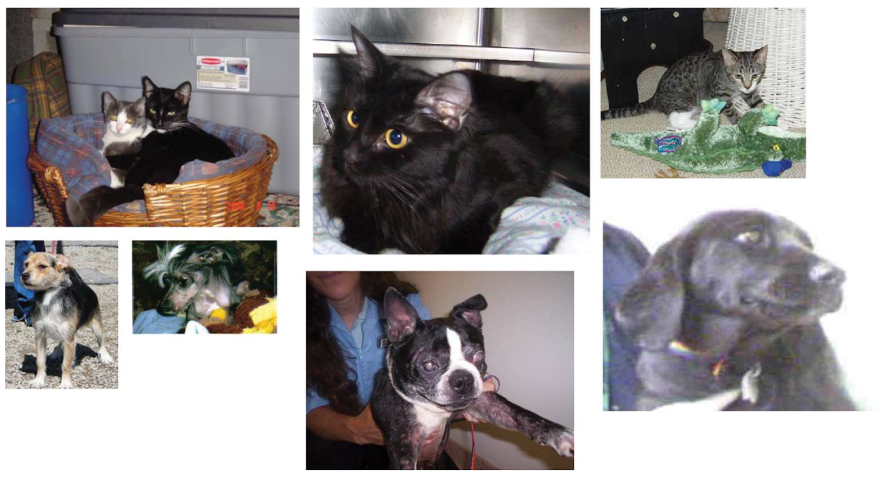

[Fuente imagen Collet 2022]

**Copiando los archivos a los directorios de entrenamiento, validación y test**

Aunque el conjunto de datos tiene `25.000` imágenes, vamos a utilizar un subconjunto para hacer el problema más tratable computacionalmente y al mismo tiempo más complejo y cercano al mundo real (no es habitual topar con bases de datos con tantas imágenes).

Por ello, el siguiente código crea una jerarquía de ficheros en la que tendremos `1.000` imágenes para entrenar, `500` para validar y `1.000` para testeo.

In [ ]:
import os, shutil, pathlib

# Directorio donde se descomprimió el dataset original
original_dir = pathlib.Path("train")
# Directorio donde vamos a introducir nuestro nuevo dataset
new_base_dir = pathlib.Path("dogs_vs_cats_small")

# Utilidad para copiar las imágenes de gatos (luego de perros) desde el índice
# `start_index` al índice `end_index` al subdirectorio
# `new_base_dir/{subset_name}/cat` (lueg, 'dog'). "subset_name"
# será "train", "validation" o "test".
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# Crear "training" con las primeras 1000 imágenes de cada categoría
make_subset("train", start_index=0, end_index=1000)
# Crear "validation" con las 500 siguientes
make_subset("validation", start_index=1000, end_index=1500)
# Crear "test" con las 1000 siguientes
make_subset("test", start_index=1500, end_index=2500)

### Construyendo el modelo

**Instantiating a small convnet for dogs vs. cats classification**

Reutilizaremos la misma estructura general del modelo que viste en el primer ejemplo: la red convolucional será una pila de capas alternadas de `Conv2D` (con activación `ReLU`) y `MaxPooling2D`.  

Pero, dado que estamos tratando con imágenes más grandes y un problema más complejo, ampliaremos nuestro modelo en consecuencia: tendrá dos etapas adicionales de `Conv2D` y `MaxPooling2D`. Esto sirve tanto para aumentar la capacidad del modelo como para reducir aún más el tamaño de los mapas de características, evitando que sean demasiado grandes cuando lleguemos a la capa `Flatten`.  

Aquí, dado que partimos de entradas de tamaño `180 x 180` píxeles (una elección algo arbitraria), terminamos con mapas de características de tamaño `7 x 7` justo antes de la capa `GlobalAveragePooling2D`. La profundidad de los mapas de características aumenta progresivamente en el modelo (de `32` a `512`), mientras que su tamaño disminuye (de `180 x 180` a `7 x 7`). Este es un patrón que verás en casi todas las redes convolucionales.  

**NOTA**  
Dado que estamos tratando con un problema de clasificación binaria, terminaremos el modelo con una única unidad (una capa `Dense` de tamaño `1`) y una activación `sigmoid`. Esta unidad codificará la probabilidad de que el modelo esté observando una clase u otra.  

Por último, una pequeña diferencia: comenzaremos el modelo con una capa de `Rescaling`, que reajustará los valores de entrada de las imágenes (originalmente en el rango `[0, 255]`) al rango `[0, 1]`.  


In [ ]:
import keras
from keras import layers

# The model expects RGB images of size 180 x 180.
inputs = keras.Input(shape=(180, 180, 3))
# Rescales inputs to the [0, 1] range by dividing them by 255
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
# Flattens the 3D activations with shape (height, width, 512) into 1D
# activations with shape (512,) by averaging them over spatial
# dimensions
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

**Configurando el modelos para el entrenamiento**

Para el paso de compilación, utilizaremos el optimizador `adam`, como de costumbre. Dado que terminamos el modelo con una única unidad `sigmoid`, usaremos `binary_crossentropy` como función de pérdida.  


In [ ]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

### Preprocesado de datos

**Utilizando `image_dataset_from_directory` para leer imágenes**

Como ya sabes, los datos deben estar formateados en tensores de punto flotante apropiadamente preprocesados antes de ser alimentados al modelo. Actualmente, los datos están almacenados en un disco como archivos JPEG, por lo que los pasos para prepararlos y pasarlos al modelo son aproximadamente los siguientes:  
1. Leer los archivos de imagen.  
2. Decodificar el contenido `JPEG` en cuadrículas `RGB` de píxeles.  
3. Convertirlos en tensores de punto flotante.  
4. Redimensionarlos a un tamaño común (usaremos `180 x 180`).  
5. Agruparlos en lotes (usaremos lotes de `64` imágenes).  

Puede parecer un proceso complicado, pero afortunadamente Keras tiene utilidades que se encargan de estos pasos automáticamente. En particular, Keras incluye la función `image_dataset_from_directory()`, que permite configurar rápidamente un flujo de datos que convierte automáticamente los archivos de imagen en disco en lotes de tensores preprocesados.  

Llamar a `image_dataset_from_directory(directory)` primero listará los subdirectorios dentro de `directory` y asumirá que cada uno contiene imágenes de una de nuestras clases. Luego indexará los archivos de imagen en cada subdirectorio. Finalmente, creará y devolverá un objeto `tf.data.Dataset` configurado para leer estos archivos y barajarlos.  


In [ ]:
from keras.utils import image_dataset_from_directory

batch_size = 64
image_size = (180, 180)
train_dataset = image_dataset_from_directory(
    new_base_dir / "train", image_size=image_size, batch_size=batch_size
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", image_size=image_size, batch_size=batch_size
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test", image_size=image_size, batch_size=batch_size
)

#### Entendiendo los objetos `TensorFlow Dataset`

TensorFlow proporciona la API `tf.data` para crear flujos de entrada eficientes en modelos de aprendizaje automático. Su clase principal es `tf.data.Dataset`.  

Un objeto `Dataset` es un iterador: puedes usarlo en un bucle `for`. Normalmente, devolverá lotes de datos de entrada y etiquetas. Puedes pasar un objeto `Dataset` directamente al método `fit()` de un modelo en Keras.  

La clase `Dataset` maneja muchas características clave que de otro modo serían difíciles de implementar por tu cuenta, en particular, la prelectura asíncrona de datos (*prefetching*), que permite procesar el siguiente lote de datos mientras el modelo maneja el anterior, manteniendo la ejecución sin interrupciones.  

La clase `Dataset` también expone una API funcional para modificar conjuntos de datos. Aquí tienes un ejemplo rápido: vamos a crear una instancia de `Dataset` a partir de un array de NumPy con números aleatorios. Consideraremos `1,000` muestras, donde cada muestra es un vector de tamaño `16`:


In [ ]:
import numpy as np
import tensorflow as tf

random_numbers = np.random.normal(size=(1000, 16))
# El método de clase from_tensor_slices() puede usarse para crear un Dataset
# de un array NumPy o de una tupla tuple o de un diccionario de arrays NumPy.
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

Al principio, nuestro dataset solo devuelve muestras individuales:

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

Podemos usar el método .batch() para agrupar los datos en lotes:

In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

Más ampliamente, tenemos acceso a una serie de métodos útiles en `Dataset`, tales como:
- `.shuffle(buffer_size)`: Mezcla elementos dentro de un búfer.
- `.prefetch(buffer_size)`: Prelectura de elementos en memoria GPU para mejorar la utilización del dispositivo.
- `.map(callable)`: Aplica una transformación arbitraria a cada elemento del dataset (donde `callable` es una función que espera recibir como entrada un solo elemento del dataset).

El método `.map()` es especialmente útil y lo usarás con frecuencia. Aquí tienes un ejemplo: usaremos `.map()` para remodelar los elementos de nuestro dataset de forma (16,) a (4, 4):

In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

**Mostrando los `shapes` y las etiquetas del `Dataset`**

Miremos la salida de uno de estos objetos `Dataset`: devuelve lotes de imágenes `RGB` de `180 x 180` (con forma `(64, 180, 180, 3)`) y etiquetas enteras (con forma `(64,)`). Hay `64` muestras en cada lote (el tamaño del lote).  


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

**Ajustar el modelo mediante un `Dataset`**

Vamos a ajustar el modelo en nuestro conjunto de datos. Utilizaremos el argumento `validation_data` en `fit()` para monitorizar las métricas de validación en un objeto `Dataset` separado.  

Ten en cuenta que también utilizaremos un *callback* `ModelCheckpoint` para guardar el modelo después de cada época. Lo configuraremos con la ruta que especifica dónde guardar el archivo, así como los argumentos `save_best_only=True` y `monitor="val_loss"`: estos le indican al *callback* que solo guarde un nuevo archivo (sobrescribiendo cualquier archivo anterior) cuando el valor actual de la métrica `val_loss` sea más bajo que en cualquier momento previo durante el entrenamiento. Esto garantiza que el archivo guardado siempre contendrá el estado del modelo correspondiente a su mejor época de entrenamiento, en términos de su rendimiento en los datos de validación. Como resultado, no tendremos que volver a entrenar un modelo por un menor número de épocas si comenzamos a sobreajustar: simplemente podemos volver a cargar el archivo guardado.


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

**NOTA**: Este entrenamiento llevará mucho tiempo, puedes bajarlo a una época. Incluiremos el resultado esperado para 50 épocas en las siguientes celdas para que no tengas que realizarlo.

**Mostrando las curvas de la pérdida y la precisión durante el entrenamiento**

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

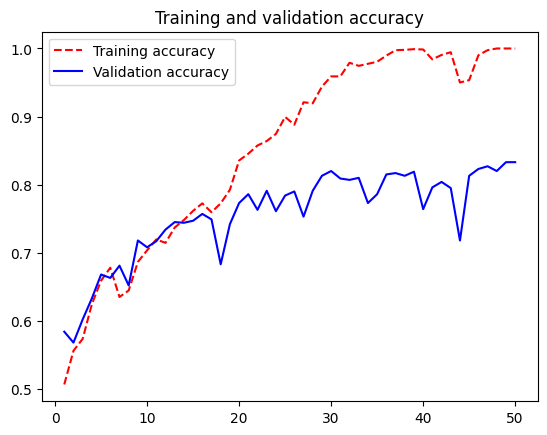

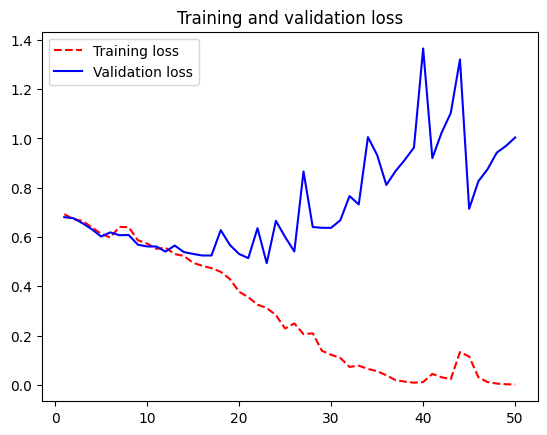

Estos gráficos son característicos del sobreajuste. La precisión en el entrenamiento aumenta linealmente con el tiempo, hasta alcanzar el `100%`, mientras que la precisión en la validación alcanza su punto máximo en el `80%`. La pérdida de validación llega a su mínimo después de solo diez épocas y luego se estabiliza, mientras que la pérdida de entrenamiento sigue disminuyendo linealmente a medida que avanza el entrenamiento.


**Evaluando el modelo en el conjunto de test**

Vamos a comprobar la precisión en el conjunto de test. Recargaremos el modelo desde su archivo guardado para evaluarlo tal como estaba antes de comenzar a sobreajustar.

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Obtenemos una precisión en la prueba de `78.8%` (debido a la aleatoriedad de las inicializaciones de redes neuronales, podrías obtener números dentro de un punto porcentual de ese valor).  

Debido a que tenemos relativamente pocas muestras de entrenamiento (`2,000`), el sobreajuste será nuestra principal preocupación. Ya conoces varias técnicas que pueden ayudar a mitigar el sobreajuste, como el *dropout* y la decaimiento de pesos (regularización L2). Ahora vamos a trabajar con una nueva técnica, específica para visión por computadora y usada casi universalmente cuando se procesan imágenes con modelos de aprendizaje profundo: el **aumento de datos**.


### Utilizando el aumento de datos (*data augmentation*)

El sobreajuste es causado por tener demasiadas pocas muestras para aprender, lo que te impide entrenar un modelo que pueda generalizar a nuevos datos. Dado un número infinito de datos, tu modelo estaría expuesto a todos los aspectos posibles de la distribución de los datos en cuestión: nunca sobreajustarías.  

El aumento de datos sigue el enfoque de generar más datos de entrenamiento a partir de las muestras de entrenamiento existentes, mediante la aplicación de una serie de transformaciones aleatorias que producen imágenes que parecen creíbles. El objetivo es que, durante el entrenamiento, tu modelo nunca vea la misma imagen exacta dos veces. Esto ayuda a exponer al modelo a más aspectos de los datos, lo que le permite generalizar mejor.


**Definir una fase de aumento de datos para añadir al modelo**

En Keras, esto se puede hacer mediante capas de aumento de datos (*data augmentation layers*). Estas capas pueden añadirse de dos maneras:

- **Al inicio del modelo**. Dentro del modelo. En nuestro caso, las capas irían justo antes de la capa `Rescaling`.  
- **Dentro del *data pipeline***. Fuera del modelo. En nuestro caso, las aplicaríamos a nuestro `Dataset` mediante una llamada a `map()`.

La principal diferencia entre estas dos opciones es que el aumento de datos realizado dentro del modelo se ejecuta en la GPU, igual que el resto del modelo. En cambio, el aumento de datos realizado en el *data pipeline* se ejecuta en la CPU, normalmente de forma paralela utilizando varios núcleos.  

En algunos casos puede haber ventajas de rendimiento al optar por la primera opción, pero normalmente la segunda suele ser la mejor alternativa. Así que vamos a elegir esa:

In [ ]:
# Definir las transformaciones a aplicar como una lista
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
]

# Crear una función que las aplica de forma secuencial
def data_augmentation(images, targets):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images, targets

# Mapear la función en el dataset
augmented_train_dataset = train_dataset.map(
    data_augmentation, num_parallel_calls=8
)
# Habilitar la precarga de batches en GPU: muy importante para mejorar el
# rendimiento
augmented_train_dataset = augmented_train_dataset.prefetch(tf.data.AUTOTUNE)

Estas son solo algunas de las capas disponibles (para más, consulta la documentación de Keras). Vamos a repasar rápidamente este código:

- `RandomFlip("horizontal")` — Aplica un volteo horizontal aleatorio al 50% de las imágenes que lo atraviesan.
- `RandomRotation(0.1)` — Rota las imágenes de entrada por un valor aleatorio en el rango `[–10%, +10%]` (estos son fracciones de un círculo completo; en grados, el rango sería `[–36 grados, +36 grados]`).
- `RandomZoom(0.2)` — Hace un zoom hacia adentro o hacia afuera de la imagen por un factor aleatorio en el rango `[-20%, +20%]`.

**Mostrando algunas imágenes aumentadas**

In [ ]:
plt.figure(figsize=(10, 10))
# Puedes usar take(N) para obtener solo N batches del dataset
# Sería equivalente a insertar un brake en el for después del N-ésimo
# batch
for image_batch, _ in train_dataset.take(1):
    image = image_batch[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image, _ = data_augmentation(image, None)
        augmented_image = keras.ops.convert_to_numpy(augmented_image)
        # Mostrar la primera imagen en el batch. Para cada una de las 9
        # iteraciones esto sería una transformación distinta
        plt.imshow(augmented_image.astype("uint8"))
        plt.axis("off")

Si entrenamos un nuevo modelo usando esta configuración de aumento de datos, el modelo nunca verá la misma entrada dos veces. Pero las entradas que ve son todavía fuertemente intercorrelacionadas porque provienen de un pequeño número de imágenes originales; no podemos producir nueva información, solo podemos remezclar la información existente. Como tal, esto puede no ser suficiente para eliminar completamente el sobreajuste. Para combatir aún más el sobreajuste, también agregaremos una capa `Dropout` a nuestro modelo justo antes del clasificador densamente conectado.  

**Definiendo una nueva CNN que tiene aumento de datos y dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

**Entrenando la CNN regularizada**

Ahora vamos a ir a más épocas, ya que esperamos que gracias a estas técnicas se reduzca el sobre ajuste.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    augmented_train_dataset,
    # Como esperamos menor overfitting, entrenamos más épocas
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Estos son los resultados que obtendrías (aproximadamente) si completas el entrenamiento:
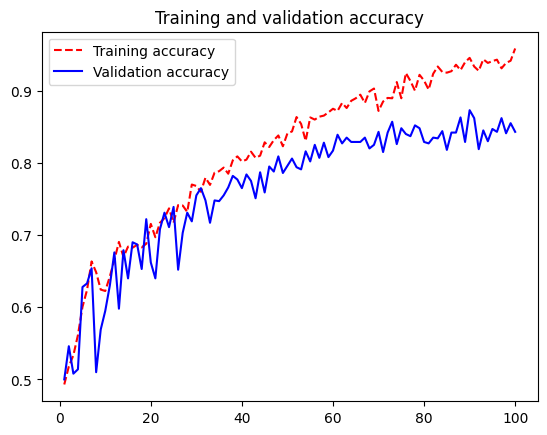
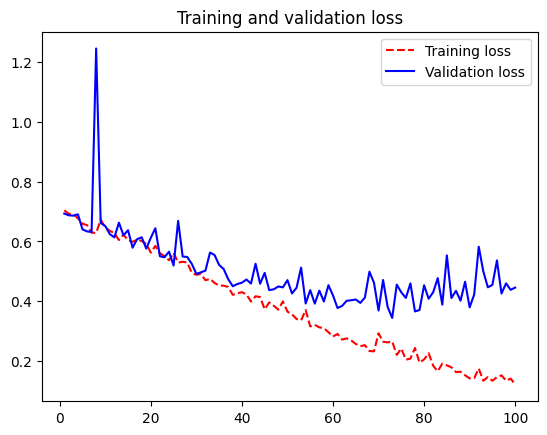

**Evaluando el modelo en el conjunto de test**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras"
)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Obtenemos una precisión en la prueba de `85.2%`. ¡Está empezando a verse bien! Si estás usando Colab, asegúrate de descargar el archivo guardado (`convnet_from_scratch_with_augmentation.keras`).  

Al ajustar aún más la configuración del modelo (como el número de filtros por capa de convolución o el número de capas en el modelo), podríamos ser capaces de obtener una precisión aún mejor, probablemente hasta el `90%`. Pero sería difícil llegar más alto solo entrenando nuestra propia red convolucional desde cero, porque tenemos tan pocos datos con los que trabajar. Como siguiente paso para mejorar nuestra precisión en este problema, tendremos que usar un modelo preentrenado, que es el enfoque del resto del cuaderno.


## Aprovechando un modelo pre-entrenado

Un enfoque común y altamente efectivo para el aprendizaje profundo en pequeños conjuntos de datos de imágenes es usar un modelo preentrenado. Un modelo preentrenado es un modelo que fue previamente entrenado en un gran conjunto de datos, típicamente en una tarea de clasificación de imágenes a gran escala. Si este conjunto de datos original es lo suficientemente grande y general, la jerarquía espacial de características aprendidas por el modelo preentrenado puede actuar efectivamente como un modelo genérico del mundo visual, y por lo tanto, sus características pueden resultar útiles para muchos problemas diferentes de visión por computadora, incluso si estos nuevos problemas involucran clases completamente distintas a las del problema original.  

Por ejemplo, podrías entrenar un modelo en *ImageNet* (donde las clases son principalmente animales y objetos cotidianos) y luego reutilizar este modelo entrenado para algo tan diferente como identificar muebles en imágenes. Esta portabilidad de las características aprendidas a través de diferentes problemas es una ventaja clave del aprendizaje profundo en comparación con muchos enfoques anteriores y más superficiales, y hace que el aprendizaje profundo sea muy efectivo para problemas con pocos datos.  

En este caso, consideremos una gran red convolucional entrenada en el conjunto de datos *ImageNet* (1.4 millones de imágenes etiquetadas y 1,000 clases diferentes). *ImageNet* contiene muchas clases de animales, incluidas diferentes especies de gatos y perros, por lo que puedes esperar que funcione bien en el problema de clasificación de perros contra gatos.  

Usaremos la arquitectura `Xception`. Esta puede ser tu primera experiencia con uno de estos nombres llamativos de modelos: `VGG`, `ResNet`, `Inception`, `Xception`, y así sucesivamente; te acostumbrarás a ellos porque aparecerán con frecuencia si sigues trabajando en aprendizaje profundo para visión por computadora.  

Hay dos formas de usar un modelo preentrenado: extracción de características y ajuste fino. Cubriremos ambas. Comencemos con la extracción de características.

### Extracción de características

La extracción de características consiste en utilizar las representaciones aprendidas por un modelo previamente entrenado para extraer características interesantes de nuevas muestras. Estas características luego se pasan a través de un nuevo clasificador, que se entrena desde cero.  

Como viste anteriormente, las redes convolucionales (CNNs) utilizadas para la clasificación de imágenes se componen de dos partes: comienzan con una serie de capas de convolución y agrupamiento, y terminan con un clasificador densamente conectado. La primera parte se llama la base convolucional del modelo. En el caso de las CNNs, la extracción de características consiste en tomar la base convolucional de una red previamente entrenada, pasar los nuevos datos a través de ella y entrenar un nuevo clasificador sobre la salida.  

¿Por qué reutilizar solo la base convolucional? ¿Podríamos reutilizar también el clasificador densamente conectado? En general, esto debería evitarse. La razón es que las representaciones aprendidas por la base convolucional son probablemente más genéricas y, por lo tanto, más reutilizables: los mapas de características de una CNN son mapas de presencia de conceptos genéricos en una imagen, lo que probablemente sea útil independientemente del problema de visión por computadora en cuestión. Pero las representaciones aprendidas por el clasificador serán necesariamente específicas del conjunto de clases en el que se entrenó el modelo; solo contendrán información sobre la probabilidad de presencia de esta o aquella clase en la imagen completa.  

Además, las representaciones encontradas en las capas densamente conectadas ya no contienen información sobre dónde se encuentran los objetos en la imagen de entrada; estas capas eliminan la noción de espacio, mientras que la ubicación de los objetos todavía está descrita por los mapas de características convolucionales. Para problemas donde la ubicación de los objetos es importante, las características densamente conectadas son en gran medida inútiles.  

Ten en cuenta que el nivel de generalidad (y, por lo tanto, reutilización) de las representaciones extraídas por capas de convolución específicas depende de la profundidad de la capa en el modelo. Las capas que están más cerca del inicio del modelo extraen mapas de características locales y altamente genéricas (como bordes visuales, colores y texturas), mientras que las capas más profundas extraen conceptos más abstractos (como “oreja de gato” o “ojo de perro”). Por lo tanto, si tu nuevo conjunto de datos difiere mucho del conjunto de datos en el que se entrenó el modelo original, podrías obtener mejores resultados utilizando solo las primeras capas del modelo para la extracción de características, en lugar de usar toda la base convolucional.  

En este caso, dado que el conjunto de clases de ImageNet contiene múltiples clases de perros y gatos, es probable que sea beneficioso reutilizar la información contenida en las capas densamente conectadas del modelo original. Sin embargo, elegiremos no hacerlo para cubrir el caso más general donde el conjunto de clases del nuevo problema no coincide con el conjunto de clases del modelo original.

Utilizaremos la biblioteca `KerasHub` para crear todos los modelos preentrenados que se usan en este libro. `KerasHub` contiene implementaciones en Keras de arquitecturas populares de modelos preentrenados junto con sus pesos preentrenados, que pueden descargarse a tu máquina. Incluye varias redes convolucionales (*ConvNets*) como `Xception`, `ResNet`, `EfficientNet` y `MobileNet`, así como modelos generativos de mayor tamaño que utilizaremos en los capítulos posteriores de este libro.

Probemos a utilizarla para instanciar el modelo `Xception` entrenado sobre el conjunto de datos ImageNet.



**Instanciando la base convolucional Xception**

In [ ]:
import keras_hub

conv_base = keras_hub.models.Backbone.from_preset("xception_41_imagenet")

Notarás un par de cosas. Primero, **KerasHub** utiliza el término `backbone` para referirse a la red extractora de características subyacente sin el cabezal de clasificación (es un poco más fácil de escribir que *base convolucional*). También utiliza un constructor especial llamado `from_preset()` que descargará la configuración y los pesos para el modelo **Xception**.

¿Qué significa ese `41` en el nombre del modelo que estamos usando? Por convención, las **ConvNets** preentrenadas suelen nombrarse según su *profundidad*. En este caso, el 41 significa que nuestro modelo **Xception** tiene 41 capas entrenables (capas convolucionales y densas) apiladas unas sobre otras. Es el modelo más *profundo* que hemos usado hasta ahora por un margen considerable.

Falta una pieza más antes de que podamos usar este modelo. Cada **ConvNet** preentrenada realiza cierto reescalado y cambio de tamaño de las imágenes antes del preentrenamiento. Es importante asegurarse de que nuestras imágenes de entrada coincidan; de lo contrario, nuestro modelo tendrá que volver a aprender cómo extraer características de imágenes con un rango de entrada totalmente diferente. En lugar de llevar la cuenta de qué modelos preentrenados usan un rango de entrada $[0, 1]$ para los valores de los píxeles y cuáles usan un rango $[-1, 1]$, podemos usar una capa de **KerasHub** llamada `ImageConverter` que reescalará nuestras imágenes para que coincidan con nuestro punto de control (*checkpoint*) preentrenado. Tiene el mismo constructor especial `from_preset()` que la clase `backbone`.

In [ ]:
preprocessor = keras_hub.layers.ImageConverter.from_preset(
    "xception_41_imagenet",
    image_size=(180, 180),
)

En este punto, hay dos formas en las que podrías proceder:

1.  **Ejecutar la base convolucional sobre tu conjunto de datos**, registrando su salida en una matriz `NumPy` en el disco y, a continuación, utilizar estos datos como entrada para un clasificador densamente conectado independiente. Esta solución es rápida y económica de ejecutar, ya que solo requiere procesar la base convolucional una vez por cada imagen de entrada, siendo esta la parte más costosa del flujo de trabajo. Sin embargo, por esta misma razón, esta técnica no permite utilizar el aumento de datos (*data augmentation*).
2.  **Extender el modelo que tienes (`conv_base`)** añadiendo capas `Dense` en la parte superior y ejecutando todo el proceso de extremo a extremo (*end-to-end*) sobre los datos de entrada. Esto te permitirá usar el aumento de datos, ya que cada imagen pasa por la base convolucional cada vez que el modelo la procesa. Por el mismo motivo, esta técnica es mucho más costosa computacionalmente que la primera.

Cubriremos ambas técnicas. Comencemos con el código necesario para configurar la primera: registrar la salida de `conv_base` en tus datos y usar esos resultados como entrada para un nuevo modelo.

#### Extracción rápida de características sin aumento de datos

**Extrayendo las características de Xception y las etiquetas a predecir**

Empezaremos extrayendo las características como matrices `NumPy`, llamando al método `predict()` del modelo `conv_base` en nuestros conjuntos de datos de entrenamiento, validación y prueba.

Iteremos sobre nuestros conjuntos de datos para extraer las características del modelo preentrenado.

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = preprocessor(images)
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

**Definimos y entrenamos una red densa para clasificar esas características**

In [ ]:
inputs = keras.Input(shape=(6, 6, 2048))
# Promediamos las dimensiones espaciales para alisar el mapa
x = layers.GlobalAveragePooling2D()(inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    train_features,
    train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks,
)

El entrenamiento es rápido porque sólo estamos ajustando dos capas densas.

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "r--", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

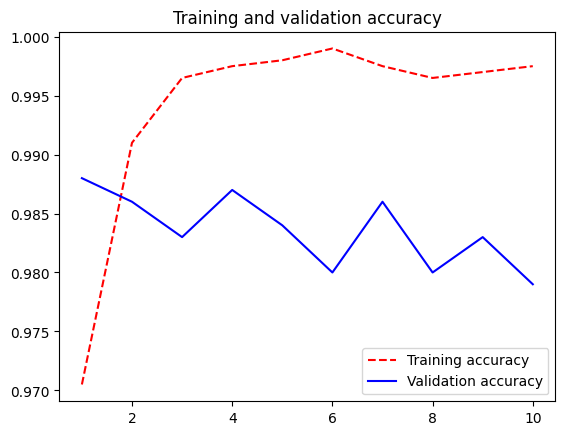
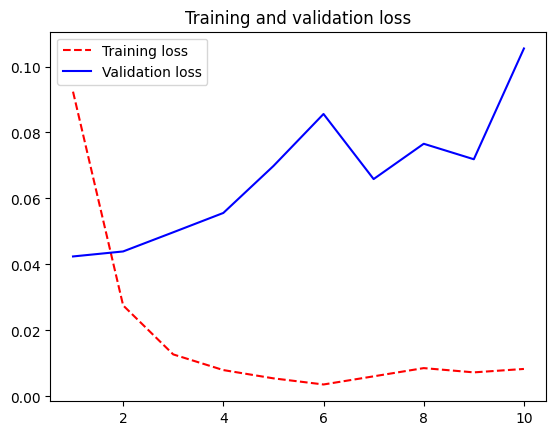

Alcanzas una precisión de validación ligeramente superior al 98%, un resultado mucho mejor que el obtenido en la sección anterior con el modelo pequeño entrenado desde cero. Sin embargo, esta es una comparación un poco injusta, ya que **ImageNet** contiene muchas instancias de perros y gatos, lo que significa que nuestro modelo preentrenado ya posee el conocimiento exacto necesario para la tarea actual. Este no será siempre el caso cuando utilices características preentrenadas.

No obstante, los gráficos también indican que estás sufriendo de sobreajuste (*overfitting*) casi desde el principio, a pesar de usar `dropout` con una tasa bastante alta. Esto se debe a que esta técnica no utiliza el aumento de datos (*data augmentation*), el cual es esencial para prevenir el sobreajuste en conjuntos de datos de imágenes pequeños.

Comprobemos la precisión en el conjunto de prueba (*test accuracy*):

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

Obtenemos una precisión en el conjunto de prueba del 98.2% — ¡una mejora muy notable respecto al entrenamiento de un modelo desde cero!

#### Extracción de características junto con aumento de datos

Ahora, revisemos la segunda técnica que mencionamos para realizar la extracción de características. Esta es mucho más lenta y costosa, pero permite utilizar el aumento de datos (*data augmentation*) durante el entrenamiento: crear un modelo que encadena la `conv_base` con un nuevo clasificador denso (`Dense`) y entrenarlo de extremo a extremo (*end-to-end*) sobre las entradas.

Para hacer esto, primero debemos **congelar** la base convolucional. Congelar una capa o un conjunto de capas significa evitar que sus pesos se actualicen durante el entrenamiento.

> **¿Por qué congelar?** Si no lo haces, las representaciones que la base convolucional aprendió previamente se modificarán durante el entrenamiento. Dado que las capas `Dense` superiores se inicializan aleatoriamente, se propagarían actualizaciones de pesos muy grandes por toda la red, destruyendo eficazmente las representaciones aprendidas anteriormente.

En **Keras**, se congela una capa o un modelo estableciendo su atributo `trainable` en `False`.

In [ ]:
import keras_hub

conv_base = keras_hub.models.Backbone.from_preset(
    "xception_41_imagenet",
    trainable=False,
)


In [ ]:
conv_base.trainable = True
len(conv_base.trainable_weights)

In [ ]:
conv_base.trainable = False
len(conv_base.trainable_weights)

Ahora, simplemente podemos crear un nuevo modelo que encadene nuestra base convolucional congelada y un clasificador denso (`Dense`), de esta manera:

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = preprocessor(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

Con esta configuración, solo se entrenarán los pesos de las dos capas `Dense` que añadiste. Eso hace un total de cuatro tensores de pesos: dos por capa (la matriz de pesos principal y el vector de sesgo o *bias*).

> **Nota importante:** Para que estos cambios surtan efecto, primero debes **compilar** el modelo. Si alguna vez modificas la capacidad de entrenamiento (`trainable`) de los pesos después de la compilación, debes volver a compilar el modelo; de lo contrario, esos cambios serán ignorados.

Entrenemos nuestro modelo. Reutilizaremos nuestro conjunto de datos aumentado `augmented_train_dataset`. Gracias al aumento de datos (*data augmentation*), el modelo tardará mucho más en empezar a sufrir sobreajuste (*overfitting*), por lo que podemos entrenar durante más épocas; hagamos 30:

Esta técnica es lo suficientemente costosa como para que solo debas intentarla si tienes acceso a una **GPU** (como la GPU gratuita disponible en **Colab**); en una **CPU** resulta inabordable. Si no puedes ejecutar tu código en una GPU, entonces la técnica anterior es el camino a seguir.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    augmented_train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

Comprobemos la convergencia:

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "r--", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

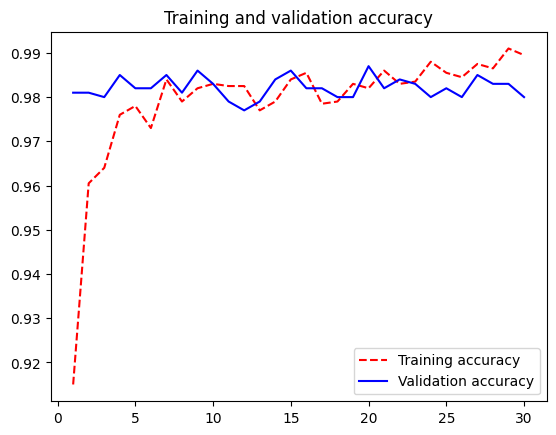

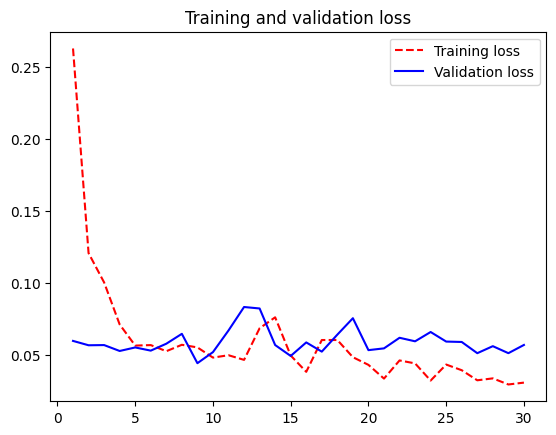

Y el rendimiento en test:

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras"
)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Obtenemos una precisión en el conjunto de prueba del 98.5%. Esto representa  una mejora mínima respecto al modelo anterior, lo cual es un poco decepcionante. Podría ser una señal de que nuestra configuración de aumento de datos (*data augmentation*) no coincide exactamente con la distribución de los datos de prueba.

Veamos si podemos obtener mejores resultados con nuestro último intento.

#### Ajuste fino de un modelo pre-entrenado

Otra técnica ampliamente utilizada para la reutilización de modelos, complementaria a la extracción de características, es el **ajuste fino** (*fine-tuning*). El ajuste fino consiste en "descongelar" la base del modelo congelada (utilizada para la extracción de características) y entrenar conjuntamente tanto la parte del modelo recién añadida (en este caso, el clasificador totalmente conectado) como la base del modelo. Se denomina "ajuste fino" porque ajusta ligeramente las representaciones más abstractas del modelo que se está reutilizando para hacerlas más relevantes para el problema en cuestión.

Mencionamos anteriormente que es necesario congelar primero la base convolucional preentrenada para poder entrenar un clasificador inicializado aleatoriamente en la parte superior. Por la misma razón, solo es posible realizar el ajuste fino de la base convolucional una vez que el clasificador superior **ya ha sido entrenado**. Si el clasificador no está entrenado, la señal de error que se propaga por la red durante el entrenamiento será demasiado grande y las representaciones aprendidas previamente por las capas que se están ajustando se destruirán.

Por lo tanto, los pasos para realizar el ajuste fino de una red son los siguientes:

1. Añadir tu red personalizada sobre una red base ya entrenada.
2. Congelar la red base.
3. Entrenar la parte que has añadido.
4. **Descongelar** la red base.
5. Entrenar conjuntamente tanto estas capas como la parte que añadiste.

> **Nota:** No se deben descongelar las capas de "normalización por lotes" (`BatchNormalization`).

Ya has completado los tres primeros pasos al realizar la extracción de características. Procedamos con el **paso 4**: descongelaremos la `conv_base`.

##### Ajuste fino parcial (*Partial fine-tuning*)

En este caso, optamos por descongelar y realizar el ajuste fino de toda la base convolucional de **Xception**. Sin embargo, al tratar con modelos preentrenados de gran tamaño, a veces es preferible descongelar solo algunas de las capas superiores de la base convolucional y dejar congeladas las capas inferiores. Probablemente te preguntes: ¿por qué realizar el ajuste fino solo de algunas capas? ¿Por qué específicamente de las superiores?

He aquí el motivo:

* **Jerarquía de características:** Las primeras capas de la base convolucional codifican características más genéricas y reutilizables (como bordes o texturas), mientras que las capas superiores codifican características más especializadas (como formas de orejas o patas). Es más útil ajustar las características más especializadas, ya que son las que deben adaptarse a tu nuevo problema. Realizar un ajuste fino en las capas inferiores ofrecería rendimientos que disminuyen rápidamente.
* **Riesgo de sobreajuste:** Cuantos más parámetros estés entrenando, mayor será el riesgo de *overfitting*. La base convolucional tiene 15 millones de parámetros, por lo que sería arriesgado intentar entrenarla por completo con un conjunto de datos pequeño.

Por lo tanto, una buena estrategia puede ser realizar el ajuste fino solo de las tres o cuatro capas superiores de la base convolucional. Se haría algo como esto:

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Comencemos el ajuste fino del modelo utilizando una **tasa de aprendizaje** (*learning rate*) muy baja. El motivo para usar una tasa de aprendizaje reducida es que queremos limitar la magnitud de las modificaciones que realizamos en las representaciones de las capas que estamos ajustando. Las actualizaciones que son demasiado grandes podrían dañar estas representaciones previamente aprendidas.

In [ ]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    augmented_train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "r--", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

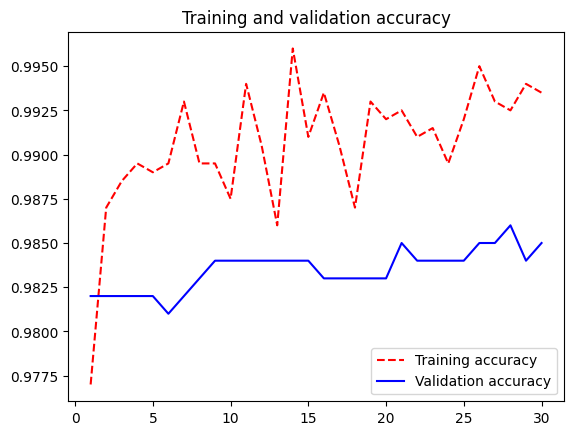
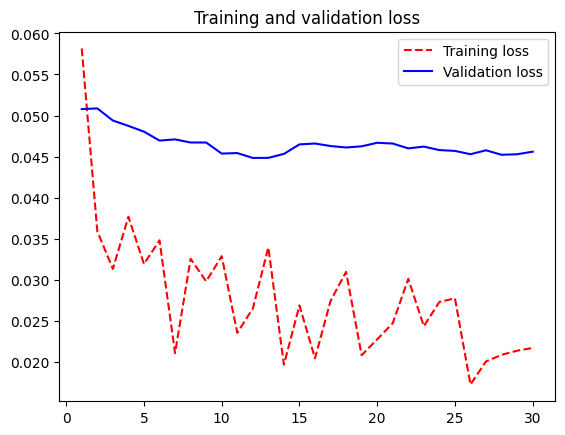

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Aquí obtienes una precisión en el conjunto de prueba del 98.5% (nuevamente, tus propios resultados pueden variar en medio punto porcentual). En la competición original de **Kaggle** sobre este conjunto de datos, este habría sido uno de los mejores resultados. Sin embargo, no es una comparación del todo justa, ya que utilizaste características preentrenadas que ya contenían conocimientos previos sobre perros y gatos, algo que los competidores no podían usar en ese momento.

En el lado positivo, mediante el uso de técnicas modernas de aprendizaje profundo (*deep learning*), lograste alcanzar este resultado utilizando solo una pequeña fracción de los datos de entrenamiento que estaban disponibles para la competición (aproximadamente el 10%). ¡Hay una diferencia abismal entre poder entrenar con 20,000 muestras frente a solo 2,000 muestras!

Ahora tienes un conjunto sólido de herramientas para lidiar con problemas de clasificación de imágenes, especialmente con conjuntos de datos pequeños.

## Resumen

* Las **CNN** (redes neuronales convolucionales) sobresalen en las tareas de visión por computadora. Es posible entrenar una desde cero, incluso con un conjunto de datos muy pequeño, obteniendo resultados decentes.
* Las **CNN** funcionan aprendiendo una jerarquía de patrones y conceptos modulares para representar el mundo visual.
* En un conjunto de datos pequeño, el sobreajuste (*overfitting*) será el problema principal. El **aumento de datos** (*data augmentation*) es una forma potente de combatir el sobreajuste cuando se trabaja con datos de imágenes.
* Es fácil reutilizar una **CNN** existente en un nuevo conjunto de datos mediante la **extracción de características** (*feature extraction*). Esta es una técnica valiosa para trabajar con conjuntos de datos de imágenes pequeños.
* Como complemento a la extracción de características, puedes usar el **ajuste fino** (*fine-tuning*), que adapta al nuevo problema algunas de las representaciones aprendidas previamente por un modelo existente. Esto eleva el rendimiento un poco más.